# concrete-crack-image-detection-With-Gabor-Filter

In [153]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [154]:
positive_dir = Path('../input/surface-crack-detection/Positive')
negative_dir = Path('../input/surface-crack-detection/Negative')

# Creating DataFrames

In [155]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [156]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,../input/surface-crack-detection/Positive/0574...,POSITIVE
1,../input/surface-crack-detection/Positive/1870...,POSITIVE
2,../input/surface-crack-detection/Positive/0967...,POSITIVE
3,../input/surface-crack-detection/Negative/0791...,NEGATIVE
4,../input/surface-crack-detection/Positive/1400...,POSITIVE
...,...,...
39995,../input/surface-crack-detection/Positive/0854...,POSITIVE
39996,../input/surface-crack-detection/Negative/1944...,NEGATIVE
39997,../input/surface-crack-detection/Positive/0977...,POSITIVE
39998,../input/surface-crack-detection/Positive/1504...,POSITIVE


In [157]:
train_df, test_df = train_test_split(
    all_df.sample(1000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

# Loading Image Data

In [158]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [159]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 560 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


# Training

In [160]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 118, 118, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 59, 59, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 57, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
global_average_pooling2d_9 ( (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33  

In [161]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
18/18 [==============================] - 2s 85ms/step - loss: 0.7054 - accuracy: 0.5486 - val_loss: 0.6868 - val_accuracy: 0.7286
Epoch 2/50
18/18 [==============================] - 1s 67ms/step - loss: 0.6853 - accuracy: 0.5900 - val_loss: 0.6847 - val_accuracy: 0.5286
Epoch 3/50
18/18 [==============================] - 1s 72ms/step - loss: 0.6822 - accuracy: 0.5449 - val_loss: 0.6802 - val_accuracy: 0.5000
Epoch 4/50
18/18 [==============================] - 1s 65ms/step - loss: 0.6782 - accuracy: 0.5826 - val_loss: 0.6781 - val_accuracy: 0.4857
Epoch 5/50
18/18 [==============================] - 1s 61ms/step - loss: 0.6766 - accuracy: 0.5483 - val_loss: 0.6637 - val_accuracy: 0.6357
Epoch 6/50
18/18 [==============================] - 1s 62ms/step - loss: 0.6621 - accuracy: 0.6899 - val_loss: 0.6516 - val_accuracy: 0.5286
Epoch 7/50
18/18 [==============================] - 1s 63ms/step - loss: 0.6493 - accuracy: 0.6115 - val_loss: 0.6384 - val_accuracy: 0.5786
Epoch 8/50
18

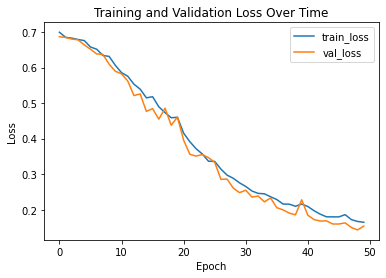

In [171]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()


# Results

In [163]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.14669
Test Accuracy: 94.00%


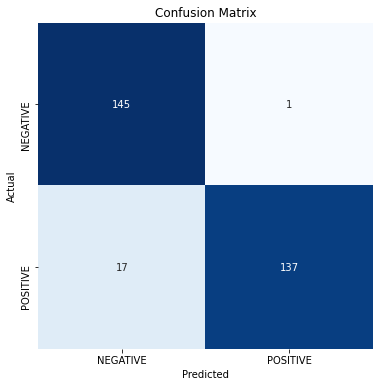

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.90      0.99      0.94       146
    POSITIVE       0.99      0.89      0.94       154

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.95      0.94      0.94       300



In [164]:
evaluate_model(model, test_data)

# Apply Gabor Filter

In [165]:
import cv2
from scipy import ndimage as ndi

# Define the Gabor filter parameters
ksize = 9  # kernel size
sigma = 0.5  # Standard deviation of the Gaussian function
theta = np.pi / 4  # Orientation of the Gabor filter
lamda = np.pi / 2  # Wavelength of the sinusoidal factor
gamma = 0.5  # Spatial aspect ratio

In [166]:
# Create the Gabor filter kernel
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)

In [167]:
def apply_gabor_filter(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply the Gabor filter kernel to the image
    filtered = ndi.convolve(gray, kernel, mode='wrap')
    return filtered.reshape(image.shape)

In [168]:
# Modify the data generator to apply Gabor filter to the images
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=apply_gabor_filter
)

In [169]:
val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)


Found 140 validated image filenames belonging to 2 classes.


In [170]:
test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 300 validated image filenames belonging to 2 classes.


Note that we have defined a function apply_gabor_filter that applies the Gabor filter kernel to the input image. We then modify the data generator